In [ ]:
# https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

# notebook
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb

In [5]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [6]:
from pprint import pprint
import numpy as np
import tensorflow as tf

# tf.enable_v2_behavior()
import tensorflow_probability as tfp

In [7]:
tfd = tfp.distributions

In [10]:
print("generate 1D data")
a = np.linspace(1, 10)
print(f"a.shape = {a.shape}")
print("")
print("Some package like to make sure that all data is at least 2D")
print("Here are two methods to do this.")
print("")
print("two ways to make 1D data into 2D data")
print("using: np.linspace(1,10)[..., np.newaxis]")
a = np.linspace(1, 10)[..., np.newaxis]
print(f"a.shape = {a.shape}")
print("using: np.linspace(1,10).reshape(-1, 1)")
a = np.linspace(1, 10).reshape(-1, 1)
print(f"a.shape = {a.shape}")
del a

generate 1D data
a.shape = (50,)

Some package like to make sure that all data is at least 2D
Here are two methods to do this.

two ways to make 1D data into 2D data
using: np.linspace(1,10)[..., np.newaxis]
a.shape = (50, 1)
using: np.linspace(1,10).reshape(-1, 1)
a.shape = (50, 1)


# generate fake data

In [11]:
# @title Synthesize dataset.
# true y-intercept
w0 = 0.125
# true gradient
b0 = 5.0

print(f"true y-intercept: {w0}")
print(f"true gradient: {b0}")

x_range = [-20, 60]


def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g ** 2.0)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1.0 + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst


y, x, x_tst = load_dataset()

true y-intercept: 0.125
true gradient: 5.0


In [12]:
x_tst.shape

(150, 1)

Text(0.5, 0, 'y')

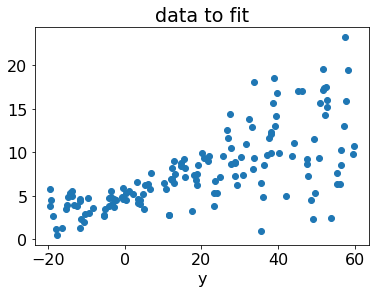

In [13]:
plt.figure()
plt.scatter(x, y)
plt.title("data to fit")
plt.xlabel("x")
plt.xlabel("y")

# linear polynomial fit

In [61]:
def run_linear_polyfit(x, y, x_tst):
    z = np.polyfit(x[:, 0], y, 1)

    gradient = z[0]
    y_intercept = z[1]

    print(f"gradient: {gradient:.5f}")
    print(f"y-intercept: {y_intercept:.5f}")

    yhat = np.poly1d(z)(x_tst)

    plt.figure()
    plt.scatter(x, y, label="data")
    plt.plot(x_tst, yhat, label="fit", c="k", lw=2)
    plt.legend()
    plt.title("linear polyfit")
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()
    plt.close()

    return z

gradient: 0.13523
y-intercept: 5.12842


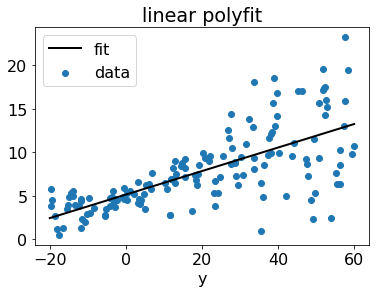

array([0.13523116, 5.1284206 ])

In [62]:
run_linear_polyfit(x, y, x_tst)

# linear regression with Neural Network

In [79]:
def run_linear_ann(x, y, x_tst):

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                1, activation="linear"
            )  # input and output layer with linear activation
        ]
    )

    optimizer = tf.optimizers.Adam(learning_rate=0.01)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])

    model.fit(x, y, epochs=1000, verbose=False)

    # this is the same as below
    # gradient = model.layers[0].kernel.numpy().squeeze()
    # y_intercept = model.layers[0].bias.numpy().squeeze()

    gradient = model.weights[0].numpy().squeeze()
    y_intercept = model.weights[1].numpy().squeeze()

    print(f"gradient: {gradient:.5f}")
    print(f"y-intercept: {y_intercept:.5f}")

    yhat = model.predict(x_tst)

    plt.figure()
    plt.scatter(x, y, label="data")
    plt.plot(x_tst, yhat, label="fit", c="k", lw=2)
    plt.legend()
    plt.title("linear neural network")
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()
    plt.close()

    return model

gradient: 0.13334
y-intercept: 5.12755


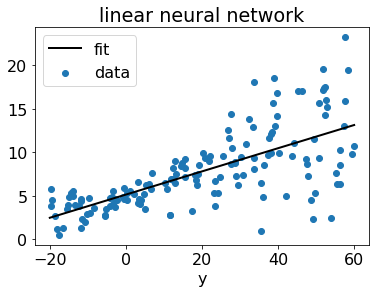

In [80]:
run_linear_ann(x, y, x_tst)

# tensorflow probability

## an aside on comparing scipy with tfp Normal distribution

In [18]:
# likelihood
# with some help from
# https://github.com/zacharyaanglin/ProbabilisticDeepLearningTensorFlow/blob/master/3%20-%20Probabilistic%20regression%20TensorFlow%20Probability%20Probabilistic%20Layers.ipynb

The likelihood function tells you what is the probability
that a given random observation occurs for the given
distribution.

It tells you, how likely/reasonable an observation is, given the
probability distribution that we assume the process is coming from.

In [19]:
import scipy.stats

scipy_norm = scipy.stats.norm
scipy_draws = scipy_norm.rvs(loc=0, scale=1, size=10000)
scipy_x = np.linspace(-5, 5, 100)
scipy_y = scipy_norm.pdf(scipy_x)
scipy_log_y = scipy_norm.logpdf(scipy_x)

In [20]:
tfp_norm = tfd.Normal(loc=0, scale=1)
tfp_draws = tfp_norm.sample([100000]).numpy()
tfp_x = np.linspace(-5, 5, 100)
tfp_y = tfp_norm.prob(tfp_x).numpy()
tfp_log_y = tfp_norm.log_prob(tfp_x).numpy()

Text(0.5, 1.0, 'Probability density function')

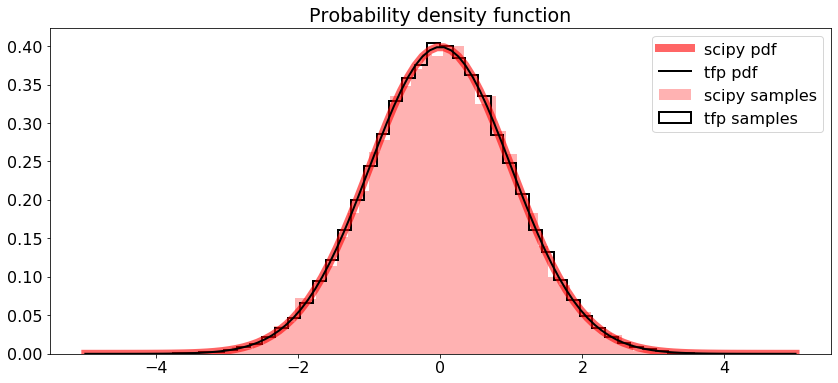

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(scipy_x, scipy_y, label="scipy pdf", c="r", ls="-", lw=8, alpha=0.6)
plt.plot(tfp_x, tfp_y, label="tfp pdf", c="k", ls="-", lw=2)
plt.hist(
    scipy_draws,
    bins=50,
    histtype="stepfilled",
    color="r",
    alpha=0.3,
    density=True,
    label="scipy samples",
)
plt.hist(
    tfp_draws,
    bins=50,
    histtype="step",
    color="k",
    density=True,
    lw=2,
    label="tfp samples",
)
plt.legend()
plt.title("Probability density function")

Text(0.5, 1.0, 'Log Probability density function')

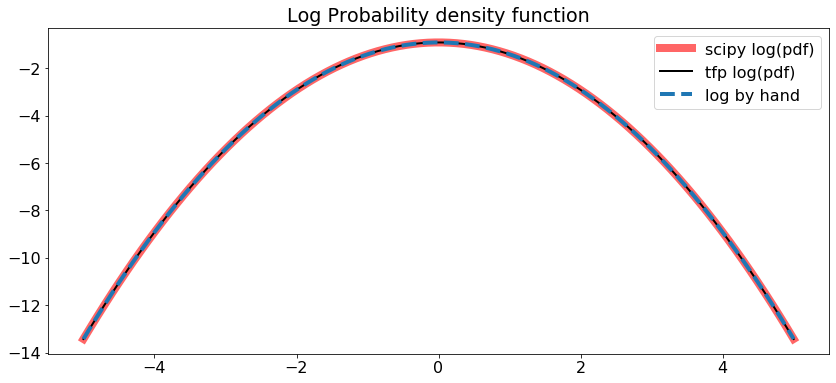

In [22]:
# to get the log-prob, just take the log of the pdf
plt.figure(figsize=(14, 6))
plt.plot(scipy_x, scipy_log_y, label="scipy log(pdf)", c="r", ls="-", lw=8, alpha=0.6)
plt.plot(tfp_x, tfp_log_y, label="tfp log(pdf)", c="k", ls="-", lw=2)

plt.plot(tfp_x, np.log(tfp_y), label="log by hand", lw=4, ls="--")

plt.legend()
plt.title("Log Probability density function")

## define likelihood

In [23]:
# rv_y is going to be a tfp.distribution.Distribution
# which has a log_prob method

# this is the same as
# tfp_norm = tfd.Normal(loc=0, scale=1)
# -tfp_norm.log_prob(y)

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

## Case 1: simple linear regression with a gaussian output and unit stdev

In [100]:
def run_case1_tfp_ann(x, y, x_tst):

    # The tfp.layers.DistributionLambda layer in fact returns a special instance of tfd.Distribution

    # This means that the neural network, rather than predicting
    # the value of x given y, is predicting the mean of a
    # normal distribution whose standard deviation is 1, given x.

    model = tf.keras.Sequential(
        [
            # input and output layer with linear activation
            tf.keras.layers.Dense(1, activation="linear"),
            # the one Neuron we have gets fed into the tfd.Normal
            # as the location parameter, with a constant stdev=1
            tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
        ]
    )
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    model.compile(loss=negloglik, optimizer=optimizer, metrics=["mae", "mse"])
    model.fit(x, y, epochs=1000, verbose=False)
    gradient = model.weights[0].numpy().squeeze()
    y_intercept = model.weights[1].numpy().squeeze()

    print(f"gradient: {gradient:.5f}")
    print(f"y-intercept: {y_intercept:.5f}")

    # instead of doing model.predict as you would normally
    # we instead just just call the model with the test set
    # which should return a tfd.Distribution object

    yhat = model(x_tst)
    assert isinstance(yhat, tfd.Distribution)

    plt.figure()
    plt.scatter(x, y, label="data")

    for i, a_sample in enumerate(yhat.sample(10)):
        if i == 0:
            label = "sample"
        else:
            label = None
        plt.plot(x_tst, a_sample, c="r", alpha=0.4, label=label)

    plt.plot(x_tst, yhat.mean(), label="mean", c="k", lw=2)
    plt.legend()
    plt.title("linear neural network with Gaussian output")
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()
    plt.close()

    return model

gradient: 0.13324
y-intercept: 5.12305


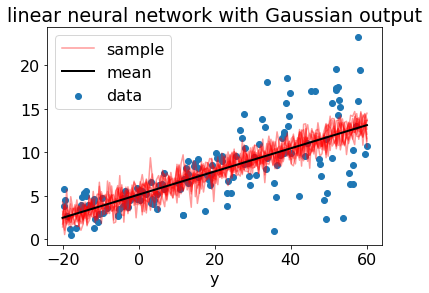

In [126]:
model_case1 = run_case1_tfp_ann(x, y, x_tst)

In [ ]:
# each sample is itself quite noisy but the mean is smoother

Thus, we managed to capture the overall trend of the data (blue circles) with the predicted mean of the distribution over labels. However, we can see that the data has more structure: it appears that the y gets more variable as x increases. The model we’ve written so far cannot capture this detail, but in the next section we’ll show how we can modify the model to give it that ability.

Text(0.5, 1.0, 'standard devation of samples - near 1 as expected')

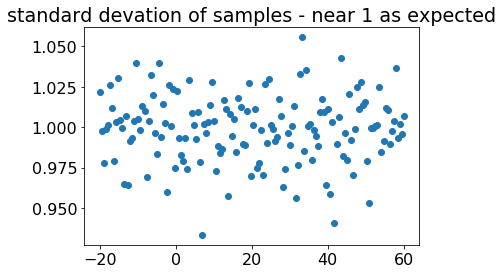

In [132]:
yhat = model_case1(x_tst)
samples = yhat.sample(1000)
del yhat
samples_std = tfp.stats.stddev(samples)

plt.figure()
plt.plot(x_tst, samples_std, "o")
plt.title("standard devation of samples - near 1 as expected")

Text(0.5, 1.0, 'standard devation of samples - near 1 as expected')

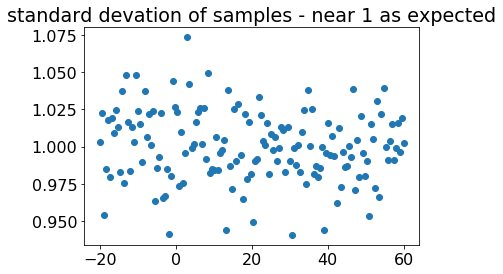

## Case 2 - Aleatoric (statistical) Uncertainty: / Known Unknowns

#### simple linear regression with a gaussian output and modelled stdev

In the previous section we’ve seen that there is variability in y for any particular value of x. We can treat this variability as being inherent to the problem. This means that even if we had an infinite training set, we still wouldn’t be able to predict the labels perfectly. A common example of this kind of uncertainty is the outcome of a fair coin flip (assuming you are not equipped with a detailed model of physics etc.). No matter how many flips we’ve seen in the past, we cannot predict what the flip will be in the future.

We will assume that this variability has a known functional relationship to the value of x. Let us model this relationship using the same linear function as we did for the mean of y.

In [116]:
def run_case2_tfp_ann(x, y, x_tst):

    model = tf.keras.Sequential(
        [
            # Here we have added another Neuron so we have TWO free parameters.
            # The second one will be used to model the standard deviation
            # the first parameter is t[...,:1] and the second is t[...,1:]
            # we write it like this to generalise to high dimensions and more parameters later
            tf.keras.layers.Dense(1 + 1, activation="linear"),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :1],
                    scale=1e-3
                    + tf.math.softplus(0.05 * t[..., 1:]),  # ensure scale is positive
                )
            ),
        ]
    )
    optimizer = tf.optimizers.Adam(learning_rate=0.05)
    model.compile(loss=negloglik, optimizer=optimizer, metrics=["mae", "mse"])
    model.fit(x, y, epochs=1000, verbose=False)

    print("model weights")
    print("first set are for the location")
    print("second set are for the stdev")
    [print(np.squeeze(w.numpy())) for w in model.weights]
    #     gradient = model.weights[0].numpy().squeeze()
    #     y_intercept = model.weights[1].numpy().squeeze()

    #     print(f"gradient: {gradient:.5f}")
    #     print(f"y-intercept: {y_intercept:.5f}")

    #     # instead of doing model.predict as you would normally
    #     # we instead just just call the model with the test set
    #     # which should return a tfd.Distribution object

    yhat = model(x_tst)
    assert isinstance(yhat, tfd.Distribution)

    mean = yhat.mean()
    std = yhat.stddev()

    plt.figure(figsize=[14, 8])
    plt.scatter(x, y, label="data")

    for i, a_sample in enumerate(yhat.sample(10)):
        if i == 0:
            label = "sample"
        else:
            label = None
        plt.plot(x_tst, a_sample, c="r", alpha=0.4, label=label)

    plt.plot(x_tst, mean, label="mean", c="k", lw=2)

    plt.plot(x_tst, mean - 2 * std, label="mean + 2 sigma", c="g", lw=2)
    plt.plot(x_tst, mean + 2 * std, label="mean - 2 sigma", c="g", lw=2)

    plt.legend()
    plt.title("linear neural network with Gaussian output and modelled stdev")
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()
    plt.close()

    return model

model weights
first set are for the location
second set are for the stdev
[0.12513776 1.0281891 ]
[ 5.2204876 31.448416 ]


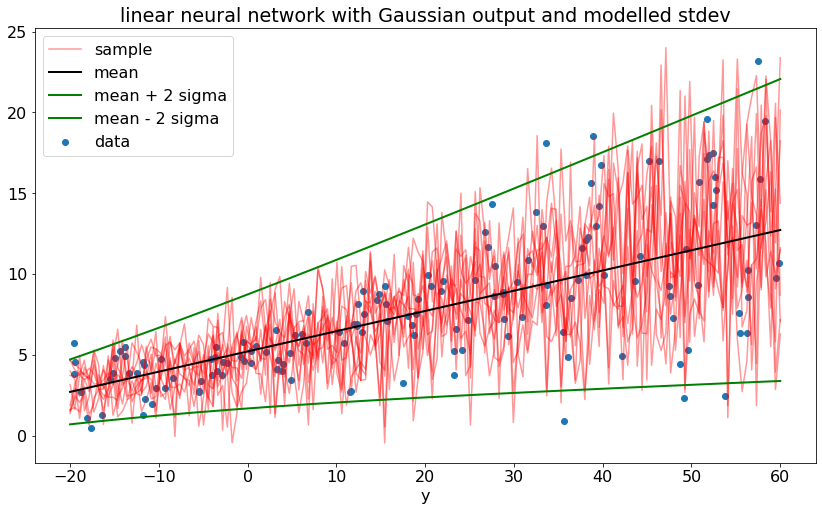

In [134]:
model_case2 = run_case2_tfp_ann(x, y, x_tst)

Much better! Our model is now less certain about what y should be as x gets larger. This kind of uncertainty is called aleatoric uncertainty, because it represents variation inherent to the underlying process . Though we’ve made progress, aleatoric uncertainty is not the only source of uncertainty in this problem. Before going further, let us consider the other source of uncertainty that we’ve hitherto ignored.

And, we've captured the heteroskedasticity present in our model now! Standard deviation in the distribution that describes the observed random variable appears to be increasing almost linearly with the random variable itself.



This sort of uncertainty is called aleatoric uncertainty -- that is, uncertainty due to the problem itself.



Text(0.5, 1.0, 'standard devation of samples - grows with x')

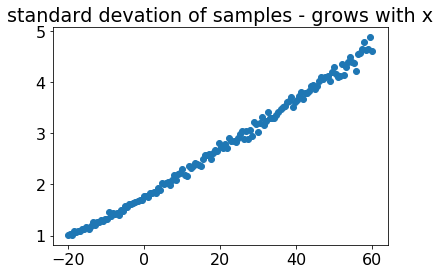

In [135]:
yhat = model_case2(x_tst)
samples = yhat.sample(1000)
del yhat
samples_std = tfp.stats.stddev(samples)

plt.figure()
plt.plot(x_tst, samples_std, "o")
plt.title("standard devation of samples - grows with x")

## Case 3 - Epistemic (systematic) Uncertainty / Unknown Unknowns

#### Specifying uncertainty in the model slope


We've outlined how to capture uncertainty in the model outputs due to the behavior of the data, but what about uncertainty in the model's definition itself? In order to do this, we'll need to replace our previous Dense layer with a Dense Variational layer, using TensorFlow Probability Distributions' nice feature of interoperability with Keras.

This is very similar to the previous DenseVariational layer we used in the last example.

The noise in the data means that we can not be fully certain of the parameters of the linear relationship between x and y. For example, the slope we’ve found in the previous section seems reasonable, but we don’t know for sure, and perhaps a slightly shallower or steeper slope would also be reasonable. This kind of uncertainty is called the epistemic uncertainty; unlike aleatoric uncertainty, epistemic uncertainty can be reduced if we get more data. To get a sense of this uncertainty we shall replace the standard Keras Dense layer with TFP’s DenseVariational layer.

The DenseVariational layer uses a variational posterior Q(w) over the weights to represent the uncertainty in their values. This layer regularizes Q(w) to be close to the prior distribution P(w), which models the uncertainty in the weights before we look into the data.



For Q(w) we’ll use a multivariate normal distribution for the variational posterior with a trainable diagonal covariance matrix centered on a trainable location. For P(w) we’ll use a standard multivariate normal distribution for the prior with a trainable location and fixed scale. See Appendix B for more details about how this layer works.

It uses variational inference and tries to get the target/posterior distribution Q(w) to match a prior distribution P(w)
with some constraints

see https://arxiv.org/abs/1505.05424

In [157]:
def run_case3_tfp_ann(x, y, x_tst):

    # Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
    def posterior_mean_fild(kernel_size, bias_size=0, dtype=None):
        """
        trainable location and stdev
        """
        n = kernel_size + bias_size
        c = np.log(np.expm1(1.0))  # expm1(x) = exp(x) - 1
        model = tf.keras.Sequential(
            [
                tfp.layers.VariableLayer(2 * n, dtype=dtype),
                tfp.layers.DistributionLambda(
                    lambda t: tfd.Independent(
                        tfd.Normal(
                            loc=t[..., :n],
                            scale=1e-5
                            + tf.nn.softplus(
                                c + t[..., n:]
                            ),  # ensure scale is positive
                        ),
                        reinterpreted_batch_ndims=1,
                    )
                ),
            ]
        )
        return model

    # Specify the prior over `keras.layers.Dense` `kernel` and `bias`
    def prior_trainable(kernel_size, bias_size=0, dtype=None):
        """
        trainable location but unit stdev
        """
        n = kernel_size + bias_size
        model = tf.keras.Sequential(
            [
                tfp.layers.VariableLayer(n, dtype=dtype),
                tfp.layers.DistributionLambda(
                    lambda t: tfd.Independent(
                        tfd.Normal(loc=t, scale=1), reinterpreted_batch_ndims=1
                    )
                ),
            ]
        )
        return model

    model = tf.keras.Sequential(
        [
            tfp.layers.DenseVariational(
                1,
                make_posterior_fn=posterior_mean_fild,
                make_prior_fn=prior_trainable,
                kl_weight=1 / x.shape[0],
            ),
            tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
        ]
    )
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    model.compile(loss=negloglik, optimizer=optimizer, metrics=["mae", "mse"])
    model.fit(x, y, epochs=1000, verbose=False)

    print("model weights")
    [print(np.squeeze(w.numpy())) for w in model.weights]

    # instead of doing model.predict as you would normally
    # we instead just just call the model with the test set
    # which should return a tfd.Distribution object

    # now we can have many instances of the model
    # each with a different fit for the data
    yhats = [model(x_tst) for _ in range(100)]
    avg_mean = np.zeros_like(x_tst[..., 0])

    plt.figure(figsize=[14, 8])
    plt.scatter(x, y, label="data")

    for i, yhat in enumerate(yhats):
        assert isinstance(yhat, tfd.Distribution)
        m = np.squeeze(yhat.mean())
        if i < 25:
            if i == 0:
                label = "enemble means"
            else:
                label = None
            plt.plot(x_tst, m, c="r", alpha=0.4, label=label)

        avg_mean += m
    avg_mean = avg_mean / len(yhats)
    plt.plot(x_tst, avg_mean, label="overall mean", c="k", lw=4)

    plt.legend()
    plt.title("linear neural network with Gaussian output and modelled stdev")
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()
    plt.close()

    return model

This time, we won't be modeling the aleatoric uncertainty in the model predictions (specified by the distribution standard deviation), but instead focus strictly on the epistemic uncertainty we have in the model's specification.

model weights
[ 0.13972424  5.1310034  -4.0526977  -2.429666  ]
[0.12749869 5.118807  ]


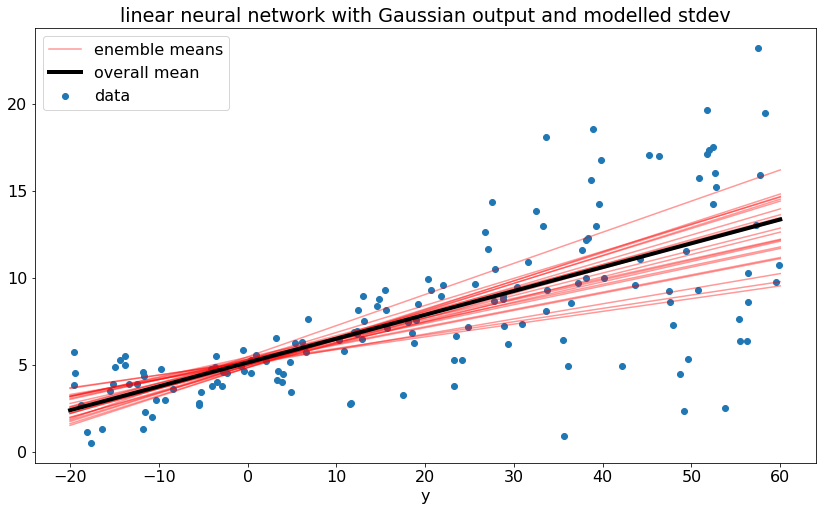

In [158]:
model_case3 = run_case3_tfp_ann(x, y, x_tst)

This is great! Now we can show the range of slopes that are potentially available to our model, rather than a simple point estimate for one of them.

Each line represents a different random draw of the model parameters from the posterior distribution. As we can see, there is in fact quite a bit of uncertainty about the linear relationship. Even if we don’t care about the variability of y for any particular value of x, the uncertainty in the slope should give us pause if we’re making predictions for x’s too far from 0.


Note that in this example we are training both P(w) and Q(w). This training corresponds to using Empirical Bayes or Type-II Maximum Likelihood. We used this method so that we wouldn’t need to specify the location of the prior for the slope and intercept parameters, which can be tough to get right if we do not have prior knowledge about the problem. Moreover, if you set the priors very far from their true values, then the posterior may be unduly affected by this choice. A caveat of using Type-II Maximum Likelihood is that you lose some of the regularization benefits over the weights. If you wanted to do a proper Bayesian treatment of uncertainty (if you had some prior knowledge, or a more sophisticated prior), you could use a non-trainable prior (see Appendix B).

## Case 4 - Aleatoric (statistical) and Epistemic (systematic) Uncertainty

Of course we can! Just as before, we can tack another output onto the Dense (now DenseVariational) layer, and use that second output to model the standard deviation of the distribution being fit to the model's outputs.

In [163]:
def run_case4_tfp_ann(x, y, x_tst):

    # Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
    def posterior_mean_fild(kernel_size, bias_size=0, dtype=None):
        """
        trainable location and stdev
        """
        n = kernel_size + bias_size
        c = np.log(np.expm1(1.0))  # expm1(x) = exp(x) - 1
        model = tf.keras.Sequential(
            [
                tfp.layers.VariableLayer(2 * n, dtype=dtype),
                tfp.layers.DistributionLambda(
                    lambda t: tfd.Independent(
                        tfd.Normal(
                            loc=t[..., :n],
                            scale=1e-5
                            + tf.nn.softplus(
                                c + t[..., n:]
                            ),  # ensure scale is positive
                        ),
                        reinterpreted_batch_ndims=1,
                    )
                ),
            ]
        )
        return model

    # Specify the prior over `keras.layers.Dense` `kernel` and `bias`
    def prior_trainable(kernel_size, bias_size=0, dtype=None):
        """
        trainable location but unit stdev
        """
        n = kernel_size + bias_size
        model = tf.keras.Sequential(
            [
                tfp.layers.VariableLayer(n, dtype=dtype),
                tfp.layers.DistributionLambda(
                    lambda t: tfd.Independent(
                        tfd.Normal(loc=t, scale=1), reinterpreted_batch_ndims=1
                    )
                ),
            ]
        )
        return model

    model = tf.keras.Sequential(
        [
            tfp.layers.DenseVariational(
                1
                + 1,  # 2 variables here so that we can also model the standard devitation
                make_posterior_fn=posterior_mean_fild,
                make_prior_fn=prior_trainable,
                kl_weight=1 / x.shape[0],
            ),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])
                )
            ),
        ]
    )
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    model.compile(loss=negloglik, optimizer=optimizer, metrics=["mae", "mse"])
    model.fit(x, y, epochs=1000, verbose=False)

    print("model weights")
    [print(np.squeeze(w.numpy())) for w in model.weights]

    # instead of doing model.predict as you would normally
    # we instead just just call the model with the test set
    # which should return a tfd.Distribution object

    # now we can have many instances of the model
    # each with a different fit for the data
    yhats = [model(x_tst) for _ in range(100)]
    avg_mean = np.zeros_like(x_tst[..., 0])
    avg_std = np.zeros_like(x_tst[..., 0])

    plt.figure(figsize=[14, 8])
    plt.scatter(x, y, label="data")

    for i, yhat in enumerate(yhats):
        assert isinstance(yhat, tfd.Distribution)
        m = np.squeeze(yhat.mean())
        s = np.squeeze(yhat.stddev())
        if i < 25:
            if i == 0:
                label = "enemble means"
            else:
                label = None
            plt.plot(x_tst, m, c="r", alpha=0.4, label=label)
        if i < 25:
            if i == 0:
                label = "enemble means - 2 enemble std"
            else:
                label = None
            plt.plot(x_tst, m - 2 * s, c="g", ls="--", alpha=0.4, label=label)
        if i < 25:
            if i == 0:
                label = "enemble means + 2 enemble std"
            else:
                label = None
            plt.plot(x_tst, m + 2 * s, c="g", alpha=0.4, label=label)

        avg_mean += m
        avg_std += s
    avg_mean = avg_mean / len(yhats)
    avg_std = avg_std / len(yhats)
    plt.plot(x_tst, avg_mean, label="overall mean", c="k", lw=4)
    plt.plot(
        x_tst,
        avg_mean - 2 * avg_std,
        label="overall mean - 2*overall std",
        c="k",
        lw=4,
        ls="--",
    )
    plt.plot(
        x_tst,
        avg_mean + 2 * avg_std,
        label="overall mean + 2*overall std",
        c="k",
        lw=4,
        ls="--",
    )

    plt.legend()
    plt.title("linear neural network with Gaussian output and modelled stdev")
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()
    plt.close()

    return model

This time, we won't be modeling the aleatoric uncertainty in the model predictions (specified by the distribution standard deviation), but instead focus strictly on the epistemic uncertainty we have in the model's specification.

model weights
[ 0.11476858  2.9348302   5.176754    4.245118   -3.5958927  -0.897357
 -2.2286296   0.09606624]
[0.12782052 2.9897618  5.22247    4.150615  ]


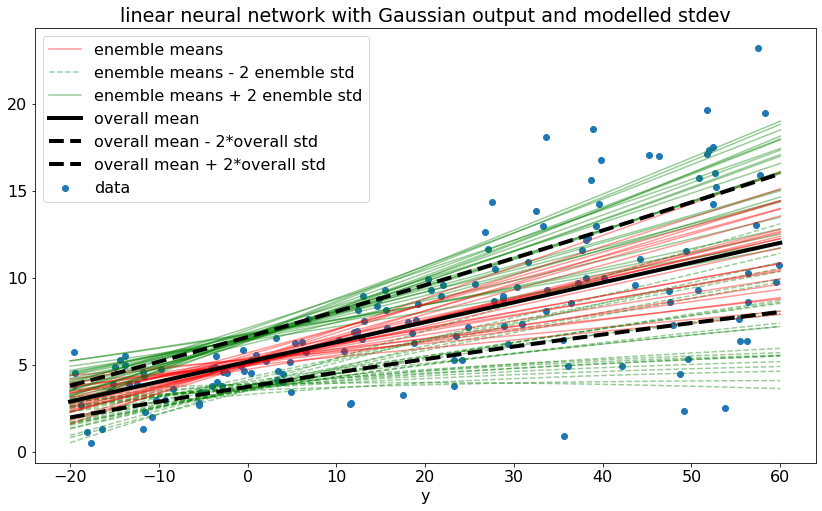

In [164]:
model_case4 = run_case4_tfp_ann(x, y, x_tst)

Note the qualitative difference between the predictions of this model compared to those from the model that considered only aleatoric uncertainty: this model predicts more variability as x gets more negative in addition to getting more positive — something that is not possible to do with a simple linear model of aleatoric uncertainty.

The guiding principle behind TFP layers is that the practitioner should focus on writing models, not losses. Throughout this post we have kept the user-specified loss the same, the negloglik function that implements the negative log-likelihood, while making local alterations to the model to handle more and more types of uncertainty. The API also lets you freely switch between Maximum Likelihood learning, Type-II Maximum Likelihood and and a full Bayesian treatment. We believe that this API significantly simplifies construction of probabilistic models and are excited to share it with the world.

This API will be ready to use in the next stable release, TensorFlow Probability 0.7.0, and is already available in the nightly version. Please join us on the tfprobability@tensorflow.org forum for the latest TensorFlow Probability announcements and other TFP discussions.

# case 5: Functional Uncertainty

So far we’ve been assuming that the data follows a line. What if we don’t know the functional relationship between the inputs and the labels? Suppose we have a vague sense that the predicted labels should be similar to the labels already seen only if the corresponding inputs are close to what we’ve already observed? In other words, the only assumption we wish to make is that the function we’re fitting to the data is smooth.

The standard tool for doing regression while making these sorts of assumptions is the Gaussian Process. This powerful model uses a kernel function to encode the smoothness assumptions (and other global function properties) about what form the relationship between the inputs and labels should take. Conditioned on the data, it forms a probability distribution over functions that are consistent with those assumptions and the data.

TFP provides the VariationalGaussianProcess layer, which uses a variational approximation (similar in spirit to what we did in case 3 and 4 above) to a full Gaussian Process for an efficient yet flexible regression model. For simplicity, we’ll be considering only the epistemic uncertainty about the form of the relationship between inputs and labels. In terms of the assumptions we’ll be making, we’ll simply assume that the function we’re fitting is locally smooth: it can vary as much as it wants across the entire dataset, but if two inputs are close, it’ll return similar values.

### create a radial basis function kernel for the GPR

In [ ]:
# @title Custom PSD Kernel
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get("dtype", None)

        #         add_weight
        #         add_variable
        self._amplitude = self.add_weight(
            initializer=tf.constant_initializer(0), dtype=dtype, name="amplitude"
        )

        self._length_scale = self.add_weight(
            initializer=tf.constant_initializer(0), dtype=dtype, name="length_scale"
        )

    def call(self, x):
        # Never called -- this is just a layer so it can hold variables
        # in a way Keras understands.
        return x

    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=tf.nn.softplus(0.1 * self._amplitude),
            length_scale=tf.nn.softplus(5.0 * self._length_scale),
        )

## case 5 epistemic

In [197]:
def run_case5_tfp_ann(x, y, x_tst):
    # For numeric stability, set the default floating-point dtype to float64
    tf.keras.backend.set_floatx("float64")
    # tf.keras.backend.set_floatx("float32") # if you use this then you can get the following error
    # InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

    # Build model.
    num_inducing_points = 40
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=[1]),
            tf.keras.layers.Dense(1, kernel_initializer="ones", use_bias=False),
            tfp.layers.VariationalGaussianProcess(
                num_inducing_points=num_inducing_points,
                kernel_provider=RBFKernelFn(),
                event_shape=[1],
                inducing_index_points_initializer=tf.constant_initializer(
                    np.linspace(*x_range, num=num_inducing_points, dtype=x.dtype)[
                        ..., np.newaxis
                    ]
                ),
                unconstrained_observation_noise_variance_initializer=(
                    tf.constant_initializer(np.array(0.54).astype(x.dtype))
                ),
            ),
        ]
    )

    # Do inference.
    batch_size = 32
    loss = lambda y, rv_y: rv_y.variational_loss(
        y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0]
    )
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
    model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)

    # Profit.
    yhat = model(x_tst)
    assert isinstance(yhat, tfd.Distribution)

    plt.figure(figsize=[14, 7])  # inches
    plt.plot(x, y, "b.", label="observed")

    num_samples = 7
    for i in range(num_samples):
        sample_ = yhat.sample().numpy()
        plt.plot(
            x_tst,
            sample_[..., 0].T,
            "r",
            linewidth=0.9,
            label="ensemble means" if i == 0 else None,
        )

    plt.plot(x_tst, yhat.mean(), c="k", label="ANN GPR mean")

    plt.ylim(-0.0, 17)
    plt.yticks(np.linspace(0, 15, 4)[1:])
    plt.xticks(np.linspace(*x_range, num=9))

    ax = plt.gca()
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.spines["left"].set_position(("data", 0))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.spines['left'].set_smart_bounds(True)
    # ax.spines['bottom'].set_smart_bounds(True)
    plt.legend(
        loc="center left", fancybox=True, framealpha=0.0, bbox_to_anchor=(1.05, 0.5)
    )

    plt.show()
    plt.close()

    return model


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



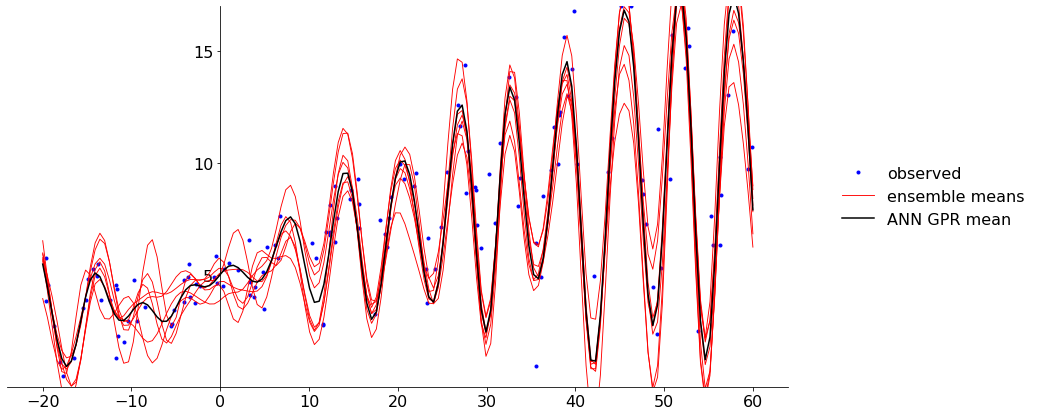

In [199]:
model_case5 = run_case5_tfp_ann(x, y, x_tst)